In [1]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
from tqdm import trange
import jsonlines
from scipy import sparse
from os import listdir
import itertools
import networkx as nx
import re
from collections import Counter
import json
import pymorphy2 as pm
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression


stopwords_ru = set(stopwords.words('russian'))
tknzr = TweetTokenizer()
morph = pm.MorphAnalyzer()

In [2]:
ok_set = set()
with open("sources/accepted_categories.txt", mode="r", encoding="utf-8") as inp:
    for line in inp:
        line = line[:-1]
        ok_set.add(line)

ok = sorted(ok_set)

categories_dict = {}
with open("sources/article_cat.json", mode="r") as input:
    categories_dict = json.loads(input.read())
    
cat_id = {}
with open("sources/cat_id.json", mode="r") as input:
    cat_id = json.loads(input.read())
    
id_cat ={}
with open("sources/id_cat.json", mode="r") as input:
    id_cat = json.loads(input.read())
 
cat_graph = nx.read_gpickle("sources/graph_gpickle.gpickle")

'''categories = [d['categories'] for d in data]
categories = sorted(set(list(itertools.chain(*categories))))

categories_dict = {c: 0 for c in categories}
for d in data:
    for c in d['categories']:
        if categories_dict.get(c) is not None:
            categories_dict[c] += 1
            
ok = [c for c in categories if categories_dict[c] > 5 and categories_dict[c] < 5000]
ok_set = set(ok)
categories_dict = {d['id']: [c for c in d['categories'] if c in ok_set] for d in tqdm(data)}
len(ok)'''

"categories = [d['categories'] for d in data]\ncategories = sorted(set(list(itertools.chain(*categories))))\n\ncategories_dict = {c: 0 for c in categories}\nfor d in data:\n    for c in d['categories']:\n        if categories_dict.get(c) is not None:\n            categories_dict[c] += 1\n            \nok = [c for c in categories if categories_dict[c] > 5 and categories_dict[c] < 5000]\nok_set = set(ok)\ncategories_dict = {d['id']: [c for c in d['categories'] if c in ok_set] for d in tqdm(data)}\nlen(ok)"

### Тут fastText

In [ ]:
global_boy = 0

def error_safe_gen(gen):
    global global_boy
    while True:
        try:
            yield next(gen)
        except StopIteration:
            raise
        except Exception as e:
            global_boy += 1
            pass

vectors = {}
dimentions = 0
with open('wiki.ru.vec', 'r', encoding='utf-8') as f_vectors:
    file_stats = f_vectors.readline().split()
    print(file_stats)
    length = int(file_stats[0])
    dimentions = int(file_stats[1])
    for line in tqdm(error_safe_gen(f_vectors), total=length):
        line = line.split()
        if line[0] not in stopwords_ru:
            vectors[line[0]] = np.array([float(l) for l in line[len(line) - dimentions:]])
  
    print(global_boy)

In [7]:
text_vectors = {}
with jsonlines.open('sources/texts.jl', 'r') as data:
    for d in tqdm(data):
        if len(set(d['categories']).intersection(ok_set)) > 0:
            text_vec = np.zeros(dimentions)
            id = d['id']
            text = d['text']
            words = text.split()
            words = [w for w in words if w != '.' and w != ',']
            n = 0
            for w in words:
                vec = vectors.get(w)
                if vec is not None:
                    if len(vec) != 300:
                        print(w)
                        print(vec)
                    text_vec += vec
                    n += 1
            if n == 0:
                continue
            text_vec = text_vec / n
            text_vectors[id] = text_vec

100%|████████████████████████████████████████████████████████████████████████| 116584/116584 [01:24<00:00, 1383.95it/s]


In [ ]:
ids_fastText = [id for id in [d['id'] for d in data] if id in text_vectors.keys()]
X_fastText = #...

### Тут tf-idf

In [3]:
texts = {item['id']: item['text'] for item in jsonlines.open('sources/normalized_texts.jl', 'r')}
#texts = {item['id']: item['text'] for item in jsonlines.open('sources/texts.jl', 'r')}

In [4]:
vectorizer = TfidfVectorizer(min_df=5, max_df=1000)
text_tfidf = vectorizer.fit_transform([text for (id, text) in sorted(texts.items())])

In [5]:
ids_tfidf = sorted([id for id in texts.keys()])
#svd = TruncatedSVD(n_components=500, random_state=27)
#X_tfidf = svd.fit_transform(text_tfidf)
X_tfidf = text_tfidf

In [9]:
np.save("sources/svd", X_tfidf)

### Тут $\theta^{\top}$ где $ \theta = p(t|d)$ матрица из PLSA

In [3]:
theta = json.loads(open("sources/plsa_res.json", "r").read())
ids_theta = sorted(theta.keys())
X_plsa = [item[1] for item in sorted(theta.items())]
X_plsa = sparse.csc_matrix(X_plsa)

### Применяем knn

In [4]:
ids = ids_theta
print(len(ids))

Y = sparse.dok_matrix((len(ids), len(ok)), dtype=np.int)
for i in trange(len(ids)):
    for c in categories_dict[ids[i]]:
        Y[i, ok.index(c)] = 1

#X = np.array([text_vectors[id] for id in ids])

96792


100%|██████████████████████████████████████████████████████████████████████████| 96792/96792 [00:31<00:00, 3076.52it/s]


In [5]:
X = X_plsa
#X = X_tfidf
X.shape

(96792, 1000)

### KNN с различными метриками

In [6]:
Y = Y.toarray()

kf = KFold(n_splits=5, shuffle=True)


train_index, test_index = 0, 0
for item in kf.split(X):
    train_index, test_index = item[0], item[1]
    break

print("TRAIN:", train_index, "TEST:", test_index)
print(len(train_index))
print(len(test_index))
X_train = X[train_index]
Y_train = Y[train_index]
print('Ok')

TRAIN: [    0     1     3 ... 96788 96790 96791] TEST: [    2    17    30 ... 96786 96787 96789]
77433
19359
Ok


In [7]:
def dag_metric(Y, _Y):
    path_cost = 0
    for to_true in Y:
        for to_pred in _Y:
            mutual_path_len = 0
            while mutual_path_len < min(len(to_pred), len(to_true)) and to_true[mutual_path_len] == to_pred[mutual_path_len]:
                mutual_path_len += 1

            side_error = len(to_pred[mutual_path_len - 1:])
            if side_error != 0:
                _path_cost = (mutual_path_len) / max(len(to_pred), len(to_true)) / len(to_pred[mutual_path_len - 1:])
            else:
                _path_cost = (mutual_path_len) / max(len(to_pred), len(to_true))
            if _path_cost > path_cost:
                path_cost = _path_cost
    return path_cost


def scoring(TRUE, PRED, G, source):
    bests = 0
    for true in TRUE:
        best = 0
        for pred in PRED:
            To_true = list(nx.all_shortest_paths(G, source, true))
            To_pred = list(nx.all_shortest_paths(G, source, pred))
            _best = dag_metric(To_true, To_pred)
            if _best > best:
                best = _best
        bests += best

    return bests/len(TRUE)

In [8]:
def MGIA(TRUE, PRED, G):
    M = len(PRED)
    N = len(TRUE)
    flow= nx.DiGraph()
    G = G.to_undirected()
    infinity = 20 #G.number_of_edges()
    flow.add_node('source', demand=0)
    flow.add_node('sink', demand=M-N)
    flow.add_node('DP', demand=0)
    flow.add_node('DT', demand=0)
    flow.add_edge('source', 'DP', capacity=N, weight=0)
    flow.add_edge('DT', 'sink', capacity=M, weight=0)
    flow.add_edge('sink', 'source', capacity=(M)*(N+1), weight=0)
    for pred in PRED:
        _pred = 'p' + str(pred)
        flow.add_node(_pred, demand=-1)
        flow.add_edge('source', _pred, capacity=N, weight=0)
        flow.add_edge(_pred, 'DT', capacity=1, weight=infinity)
    for true in TRUE:
        _true = 't' + str(true)
        flow.add_node(_true, demand=1)
        flow.add_edge(_true, 'sink', capacity=M, weight=0)
        flow.add_edge('DP', _true, capacity=1, weight=infinity)
        for pred in PRED:
            k_ij = nx.shortest_path_length(G, source=pred, target=true)
            flow.add_edge('p' + str(pred), _true, capacity=1, weight=k_ij)
    
    flowCost, flowDict = nx.network_simplex(flow)
    low = (len(PRED.union(TRUE).difference(PRED.intersection(TRUE))))
    if low == 0:
        accuracy = 1
    else:
        accuracy = 1 - flowCost / (len(PRED.union(TRUE).difference(PRED.intersection(TRUE))) * infinity)
    print(accuracy)
    accuracy = flowCost
    return accuracy

In [9]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1, weights='distance')
clf = knn

In [10]:
print("Training ", clf)
clf.fit(X_train, Y_train)
print("Done")
precision = 0
recall = 0
f1 = 0
g_scores = []
mgia_scores = []

Training  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='distance')
Done


In [12]:
bundle_len = 100

source = cat_id['Всё']
#splits = int(len(test_index) / bundle_len)
splits = 1

for i in trange(splits):
    X_test = X[test_index[i * bundle_len : (i+1) * bundle_len]]
    Y_test = Y[test_index[i * bundle_len : (i+1) * bundle_len]]
    res = clf.predict(X_test)
    precision += precision_score(Y_test, res, average='micro')
    recall += recall_score(Y_test, res, average='micro')
    f1 += f1_score(Y_test, res, average='micro')
    graph_score = 0
    mgia = 0
    for j in range(len(res)):
        y = np.where(Y_test[j] == 1)[0]
        TRUE = {cat_id[ok[_y]] for _y in y}
        y = np.where(res[j] == 1)[0]
        PRED = {cat_id[ok[_y]] for _y in y}
        print({id_cat[str(c)] for c in TRUE}, {id_cat[str(c)] for c in PRED})
        _mgia = MGIA(TRUE, PRED, cat_graph)
        mgia += _mgia
        print(_mgia)
    g_scores.append(graph_score / len(res))
    mgia_scores.append(mgia / len(res))

print(f1/splits)
print(recall/splits)
print(precision/splits)
#print(g_scores)
print(mgia_scores)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

{'Городские округа Иркутской области', 'Районные центры Иркутской области'} {'Переименованные населённые пункты России', 'Города, основанные в XVIII веке'}
0.8375
13
{'Эндокринология'} {'Аномалии развития', 'Кардиология'}
0.9166666666666666
5
{'Принцы Великобритании', 'Ганноверская династия', 'Принцы Уэльские', 'Королевские члены Лондонского королевского общества', 'Короли Великобритании'} {'Супруги монархов Испании', 'Эрцгерцогини Австрийские', 'Супруги монархов Неаполя', 'Габсбурги'}
0.8888888888888888
20
{'Преподаватели Йельского университета', 'Лауреаты Нобелевской премии мира'} {'Премьер-министры Болгарии'}
0.7833333333333333
13
{'Лауреаты Нобелевской премии по физике', 'Иностранные члены АН СССР', 'Награждённые медалью Хьюза', 'Члены Папской академии наук', 'Члены Французской академии наук', 'Члены-корреспонденты АН СССР', 'Награждённые медалью Маттеуччи', 'Члены Лондонского королевского общества'} {'Физики Швеции', 'Лауреаты Нобелевской премии по физике', 'Члены и члены-корреспо

{'Населённые пункты по алфавиту', 'Населённые пункты Карельского перешейка'} {'Населённые пункты Всеволожского района'}
0.85
9
{'Гидрография'} {'Русловедение'}
0.95
2
{'Индоевропейские языки'} {'Карелы', 'Финно-угорские народы', 'Народы России'}
0.8375
13
{'Ракетное топливо'} {'Ракетное топливо', 'Соединения азота по алфавиту'}
0.65
7
{'Цветок'} {'Цветок'}
1
0
{'Химики XIX века'} {'Действительные члены АН СССР', 'Химики России', 'Похороненные на Комаровском кладбище', 'Умершие в Санкт-Петербурге', 'Выпускники физико-математического факультета Санкт-Петербургского университета', 'Культурно-историческое наследие Курортного района Санкт-Петербурга', 'Родившиеся в Санкт-Петербурге'}
0.7
48
{'Писатели Франции', 'Русские писатели XVIII века', 'Лексикографы Российской империи', 'Выпускники Славяно-греко-латинской академии', 'Философы Российской империи', 'Писатели России XVIII века', 'Русские поэты', 'Церковнославянский язык'} {'Писатели Российской империи', 'Русские писатели XVIII века', 'Ма

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [09:30<00:00, 570.30s/it]


41.855707994656434
43.566799017298095
41.13034469583136
[20.49]


### Тут только predict без измерения качества

In [6]:
Y = Y.toarray()

kf = KFold(n_splits=5, shuffle=True)

clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1, weights='distance')

results_dict = {}
train_index, test_index = 0, 0
for item in kf.split(X):
    train_index, test_index = item[0], item[1]
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train = X[train_index]
    Y_train = Y[train_index]
    clf.fit(X_train, Y_train)
    
    bundle_len = 100
    splits = int(len(test_index) / bundle_len)
    precision = 0
    recall = 0
    f1 = 0
    
    for i in trange(splits):
        split_index = test_index[i * bundle_len : (i+1) * bundle_len]
        X_test = X[split_index]
        Y_test = Y[split_index]
        res = clf.predict(X_test)
        for j in range(len(res)):
            y = np.where(res[j] == 1)[0]
            PRED = {ok[_y] for _y in y}
            results_dict[ids[split_index[j]]] = PRED
            
with open("sources/res_knn.json", "w") as input:
    input.write(json.dumps(results_dict))

IndentationError: unexpected indent (<ipython-input-6-82c913a960c0>, line 28)

### С центроидами

In [ ]:
X = X_tfidf
ids = ids_tfidf

kf = KFold(n_splits=20, shuffle=True, random_state=27)


train_index, test_index = 0, 0
for item in kf.split(X):
    train_index, test_index = item[0], item[1]
    break
    
print("TRAIN:", train_index, "TEST:", test_index)
    
X_train = X_tfidf[train_index]
ids_train = [ids[i] for i in train_index]

class_centroids = {}
for category in tqdm(ok):
    clf_centroids = NearestCentroid()
    y_train = np.array([1 if category in categories_dict[id] else 0 for id in ids_train])
    if sum(y_train) > 0:
        clf_centroids.fit(X_train, y_train)
        class_centroids[category] = clf_centroids.centroids_
    else:
         print(category)   

TRAIN: [    0     1     2 ... 96791 96792 96793] TEST: [   56    71    93 ... 96715 96756 96789]


100%|██████████████████████████████████████████████████████████████████████████| 14697/14697 [1:21:46<00:00,  3.00it/s]


In [ ]:
for key in class_centroids:
    class_centroids[key] = list(class_centroids[key][1])

In [ ]:
with open("sources/centroids_nosvd.json", "w") as output:
    output.write(json.dumps(class_centroids))

In [26]:
list(class_centroids.items())[0][1][1].shape

(500,)

In [31]:
X_centroids = np.array([class_centroids[category][1] for category in sorted(class_centroids.keys())])
y_centroids = np.zeros((len(class_centroids), len(ok)), dtype=int)
for i, category in enumerate(sorted(class_centroids.keys())):
    y_centroids[i][ok.index(category)] = 1

In [35]:
print(X_centroids.shape)
y_centroids.shape

(14694, 500)


(14694, 14697)

In [38]:
Y = sparse.dok_matrix((len(ids), len(ok)), dtype=np.int)
for i in trange(len(ids)):
    for c in categories_dict[ids[i]]:
        Y[i, ok.index(c)] = 1
        
Y = Y.toarray()

In [83]:
class CustomKNN:
    
    def __init__(self, n_neighbors=5):
        self.clf = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        self.n_neighbors = n_neighbors
    
    
    def fit(self, X_train, y_train):
        self.clf.fit(X_train)
        self.categories = y_train
        
        
    def predict(self, X_test, n_neighbors=None):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
            
        kneighbors = self.clf.kneighbors(X_test, n_neighbors, return_distance=False)
        res = []
        for neighs in kneighbors:
            curr_neigh = np.zeros(self.categories.shape[1], dtype=int)
            for neigh in neighs:
                curr_neigh = np.bitwise_or(self.categories[neigh], curr_neigh)
            res.append(curr_neigh)
        
        return np.array(res)

In [101]:
#clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1, weights='distance')
for n in [1, 2, 5]:
    print("Number of neighbors: ", n);
    clf = CustomKNN(n_neighbors=n)
    print(X[train_index].shape)
    print(Y[train_index].shape)
    clf.fit(X[train_index], Y[train_index])

    bundle_len = 100
    splits = int(len(test_index) / bundle_len)
    precision = 0
    recall = 0
    f1 = 0

    for i in trange(splits):
        split_index = test_index[i * bundle_len : (i+1) * bundle_len]
        X_test = X[split_index]
        Y_test = Y[split_index]
        res = clf.predict(X_test)
        precision += precision_score(Y_test, res, average='micro')
        recall += recall_score(Y_test, res, average='micro')
        f1 += f1_score(Y_test, res, average='micro')
        for j in range(len(res)):
            y = np.where(Y_test[j] == 1)[0]
            TRUE = {cat_id[ok[_y]] for _y in y}
            y = np.where(res[j] == 1)[0]
            PRED = {cat_id[ok[_y]] for _y in y}
            print({id_cat[str(c)] for c in TRUE}, {id_cat[str(c)] for c in PRED})
        break


    print("Precision: ", precision / splits)
    print("Recall: ", recall / splits)
    print("F1: ", f1 / splits)

Number of neighbors:  1
(64529, 500)
(64529, 14697)


  0%|                                                                                          | 0/322 [00:00<?, ?it/s]

{'Семейства млекопитающих'} {'Млекопитающие Азии', 'Приложения СИТЕС', 'Фауна Южной Азии', 'Животные, описанные в 1758 году'}
{'Городские округа Иркутской области', 'Районные центры Иркутской области'} {'Городские округа Иркутской области', 'Города на Ангаре', 'Города Иркутской области'}
{'Районные центры Иркутской области', 'Города Иркутской области'} {'Населённые пункты на Байкале'}
{'Районные центры Иркутской области', 'Города Иркутской губернии'} {'Сибирское областничество', 'Умершие от туберкулёза', 'Историки по алфавиту', 'Члены Русского географического общества до 1917 года', 'Историки России', 'Этнографы России', 'Персоналии:Томск', 'Выпускники Казанской духовной академии'}
{'Христианские добродетели', 'Религия', 'Аскетизм', 'Монашество'} {'Грехи в христианстве'}
{'Горные хребты по алфавиту'} {'Библейские места', 'Горные хребты по алфавиту'}
{'Кавалеры ордена Святого Георгия III класса', 'Вюртембергский дом', 'Кавалеры ордена Святого апостола Андрея Первозванного', 'Германские 

{'Города на Каме', 'Города, основанные в XX веке'} {'Районные центры Башкортостана'}
{'Средневековая мифология'} {'Жанры фольклора'}
{'Новые созвездия'} {'Отменённые созвездия'}
{'Футболисты СССР', 'Футбольные тренеры России', 'Футбольные вратари', 'Футболисты России', 'Тренеры ФК «Крылья Советов»'} {'Писатели России XX века', 'Переводчики России', 'Выпускники Пермского государственного университета', 'Члены Союза писателей СССР', 'Поэты России'}
{'Мастера спорта СССР международного класса', 'Игроки ФК «Спартак» Москва', 'Игроки ФК «Динамо» Москва', 'Футбольные тренеры России', 'Футболисты СССР', 'Игроки сборной СССР по футболу', 'Игроки ФК «Спартак-Нальчик»', 'Игроки ФК «Динамо» Минск', 'Игроки ФК «Локомотив» Москва', 'Тренеры ФК «Локомотив» Москва'} {'Члены КПСС', 'Игроки ФК «Спартак» Москва', 'Игроки ФК ЦСКА Москва', 'Футбольные тренеры СССР', 'Футболисты СССР', 'Игроки сборной СССР по футболу', 'Тренеры ФК ЦСКА Москва', 'Мастера спорта СССР'}
{'Мастера спорта СССР международного кл

Precision:  0.0004702750665483585
Recall:  0.00042863612836438925
F1:  0.00044849120787990586
Number of neighbors:  2
(64529, 500)
(64529, 14697)


  0%|                                                                                          | 0/322 [00:00<?, ?it/s]

{'Семейства млекопитающих'} {'Фауна Южной Азии', 'Млекопитающие Азии', 'Приложения СИТЕС', 'История Индии', 'Животные, описанные в 1758 году', 'Способы и орудия смертной казни'}
{'Городские округа Иркутской области', 'Районные центры Иркутской области'} {'Городские округа Иркутской области', 'География Казахстана', 'Города на Ангаре', 'Города Иркутской области'}
{'Районные центры Иркутской области', 'Города Иркутской области'} {'Предприятия целлюлозно-бумажной промышленности СССР', 'Целлюлозно-бумажные компании России', 'Населённые пункты на Байкале'}
{'Районные центры Иркутской области', 'Города Иркутской губернии'} {'Сибирское областничество', 'Умершие от туберкулёза', 'Историки по алфавиту', 'Члены Русского географического общества до 1917 года', 'Населённые пункты на Байкале', 'Историки России', 'Этнографы России', 'Персоналии:Томск', 'Выпускники Казанской духовной академии'}
{'Христианские добродетели', 'Религия', 'Аскетизм', 'Монашество'} {'Грехи в христианстве', 'Суфийские терми

{'Органы власти времён Гражданской войны в России'} {'Преподаватели Вильнюсского университета', 'Преподаватели Университета Витовта Великого', 'Выпускники Вильнюсского университета', 'История Литвы', 'Перестройка', 'Жертвы автомобильного наезда на пешеходов'}
{'Персоналии по алфавиту', 'Античные писатели, чьи труды дошли до нашего времени', 'Драматурги Древней Греции', 'Сатирики'} {'Ораторы Древней Греции', 'Убитые политики', 'Античные писатели, чьи труды дошли до нашего времени', 'Философы IV века до н. э.', 'Философы Древней Греции', 'Политики Афин', 'Самоубийцы', 'Умершие от голода', 'Софисты', 'Философы по алфавиту'}
{'Древнегреческие историки', 'Историки по алфавиту', 'Историки Древней Греции', 'Участники Пелопоннесской войны', 'Персоналии по алфавиту', 'Античные писатели, чьи труды дошли до нашего времени'} {'Ораторы Древней Греции', 'Античные писатели, чьи труды дошли до нашего времени', 'Философы IV века до н. э.', 'Философы Древней Греции', 'Древнегреческие философы', 'Умершие

Precision:  0.0003935165489662214
Recall:  0.0005984730848861284
F1:  0.0004748216210666804
Number of neighbors:  5
(64529, 500)
(64529, 14697)


  0%|                                                                                          | 0/322 [00:00<?, ?it/s]

{'Семейства млекопитающих'} {'Шахматные фигуры', 'Фильмы о цирке', 'Фауна Южной Азии', 'Млекопитающие Азии', 'Экранизации произведений Марка Твена', 'Кинокомедии США', 'Приложения СИТЕС', 'Семейные фильмы США', 'Фильмы-драмы США', 'История Индии', 'Скульптурные материалы', 'Животные, описанные в 1758 году', 'Способы и орудия смертной казни'}
{'Городские округа Иркутской области', 'Районные центры Иркутской области'} {'Климатология', 'Городские округа Иркутской области', 'Почвоведение', 'География Казахстана', 'Глобальные проблемы', 'Города Иркутской области', 'Климат', 'Города на Ангаре'}
{'Районные центры Иркутской области', 'Города Иркутской области'} {'Города Красноярского края', 'Целлюлозно-бумажные компании России', 'Населённые пункты краевого подчинения Красноярского края', 'Населённые пункты на Байкале', 'Переименованные населённые пункты России', 'Предприятия целлюлозно-бумажной промышленности СССР', 'Города, основанные в XX веке', 'Города на Амуре', 'Посёлки городского типа За

{'Казнённые учёные', 'Выпускники Первой Санкт-Петербургской гимназии', 'Погибшие в Гражданскую войну в России', 'Выпускники юридического факультета Санкт-Петербургского государственного университета', 'Авторы Энциклопедического словаря Брокгауза и Ефрона'} {'Похороненные на кладбище Пер-Лашез', 'Выпускники 2-й Московской гимназии', 'Члены Государственной думы Российской империи от Москвы', 'Выпускники историко-филологического факультета Московского университета', 'Депутаты Ленсовета — Петросовета 1990—1993', 'Гласные Московской городской думы', 'Мемуаристы Российской империи', 'Социализм', 'Члены Государственного совета Российской империи', 'Либеральные партии', 'Юристы России', 'Дуэлянты', 'Политические партии Российской империи', 'Военнопленные Российской империи', 'Октябристы', 'Родившиеся в Санкт-Петербурге', 'Персоналии по алфавиту', 'Газеты Российской империи', 'Депутаты Законодательного собрания Санкт-Петербурга', 'Доктора юридических наук', 'Февральская революция', 'Родившиеся 

{'Рэперы США'} {'Лауреаты премии «Оскар»', 'Музыкальные коллективы, появившиеся в 1998 году', 'Альбомы Camel', 'Quake', 'Музыканты альтернативного рока', 'Лауреаты премии «Грэмми»', 'Альбомы Capitol Records', 'Музыкальные продюсеры США', 'Авторы-исполнители США', 'Лауреаты премии Kerrang! Awards', 'Концептуальные альбомы', 'Хеви-метал-вокалисты США', 'Музыканты в жанре электронной музыки', 'Музыкальные коллективы, появившиеся в 1999 году', 'Мультиинструменталисты США', 'Альбомы Parlophone', 'Рок-гитаристы США', 'Альбомы, спродюсированные Найджелом Годричем', 'Альбомы Radiohead', 'Композиторы музыки для компьютерных игр', 'Композиторы США', 'Композиторы по алфавиту', 'Лауреаты премии American Music Awards', 'Альбомы альтернативного рока', 'Рок-вокалисты США', 'Музыкальные коллективы в стиле драм-н-бейс', 'Музыкальные дуэты', 'Альбомы 1975 года', 'Альбомы прогрессивного рока', 'Музыкальные коллективы Москвы', 'Музыкальные коллективы России', 'Бас-гитаристы США', 'Альбомы, записанные на A

{'Химики XIX века'} {'Индологи Германии', 'Группы краут-рока', 'Преподаватели Галле-Виттенбергского университета', 'Музыкальные коллективы Германии', 'Города Верхней Австрии', 'Группы прогрессивного рока', 'Лингвисты Германии', 'Музыкальные коллективы, появившиеся в 1970 году', 'Обладатели Кубка Дэвиса', 'Бронзовые призёры летних Олимпийских игр 1996 года', 'Экспериментальные музыкальные коллективы'}
{'Программирование'} {'Эзотерические языки программирования', 'Системы классификации', 'Информатика', 'Программное обеспечение Apple', 'Рекомендации ITU-T', 'Языки программирования по алфавиту', 'Объектно-ориентированные языки программирования'}
{'Архиепископы Русской православной церкви', 'Ректоры Московской духовной академии', 'Епископы Русской православной церкви'} {'Митрополиты Крутицкие и Коломенские', 'Персоналии по алфавиту', 'Митрополиты Русской православной церкви', 'Богословы России', 'Архиепископы Русской православной церкви', 'Русские эмигранты первой волны в США', 'Епископы Ру

Precision:  0.00025122261673477593
Recall:  0.0008491847826086956
F1:  0.00038773716589980873


### Пробуем модели на части корпуса

In [19]:
X = X_tfidf
ids = ids_tfidf

kf = KFold(n_splits=3, shuffle=True)


train_index, test_index = 0, 0
for item in kf.split(X):
    train_index, test_index = item[0], item[1]
    break
    
print("TRAIN:", train_index, "TEST:", test_index)
print(len(train_index), len(test_index))

TRAIN: [    0     2     3 ... 96788 96789 96792] TEST: [    1    12    14 ... 96790 96791 96793]
64529 32265


In [7]:
Y = sparse.dok_matrix((len(ids), len(ok)), dtype=np.int)
for i in trange(len(ids)):
    for c in categories_dict[ids[i]]:
        Y[i, ok.index(c)] = 1
        
Y = Y.toarray()

100%|██████████████████████████████████████████████████████████████████████████| 96794/96794 [00:30<00:00, 3178.00it/s]


In [18]:
class_logregs = {}
ids_train = [ids[i] for i in train_index]
X_train = X[train_index]

for category in tqdm(ok):
    clf_logreg = LogisticRegression()
    y_train = np.array([1 if category in categories_dict[id] else 0 for id in ids_train])
    if sum(y_train) > 0:
        clf_logreg.fit(X_train, y_train)
        class_logregs[category] = clf_logreg
    else:
         print(category)  

  2%|█▎                                                                         | 250/14697 [12:32<12:04:30,  3.01s/it]

KeyboardInterrupt: 

# Черновик
# .
# .
# .
# .

In [3]:
text_vectors = {}
with jsonlines.open('texts.jl', 'r') as file:
    for text in tqdm(file):
        text_vec = np.zeros(dimentions)
        id = text['id']
        text = text['text']
        words = text.split()
        words = [w for w in words if w != '.' and w != ',']
        n = 0
        for w in words:
            vec = vectors.get(w)
            if vec is not None:
                if len(vec) != 300:
                    print(w)
                    print(vec)
                text_vec += vec
                n += 1
        text_vec = text_vec / n
        text_vectors[id] = text_vec

5107it [00:26, 189.95it/s]C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
116555it [03:55, 494.00it/s]


In [7]:
kneighbours = KNeighborsClassifier(n_neighbors=8)

print(X.shape)
print(Y.shape)
i = 0
for j in range(14301):
    i += Y[10, j]

print(i)
cross_val_score(kneighbours, X, Y)

NameError: name 'OneVsRestClassifier' is not defined

In [58]:
kneighbours = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

kf = KFold(n=len(ids), n_folds=5, shuffle=False)
for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    print(len(train_index))
    print(len(test_index))
    X_train = X[train_index]
    Y_train = Y[train_index[0]:train_index[-1]+1]
    print(X_train.shape)
    print(Y_train.shape)
    kneighbours.fit(X_train, Y_train)
    
    for i in trange(int(len(test_index) / 100)):
        X_test = X[test_index[i * 100]:test_index[(i+1) * 100]]
        Y_test = Y[test_index[i * 100]:test_index[(i+1) * 100]]
        res = kneighbours.predict(X_test)
    break

TRAIN: [18790 18791 18792 ..., 93943 93944 93945] TEST: [    0     1     2 ..., 18787 18788 18789]
75156
18790
(75156, 300)
(75156, 14301)


 12%|█████████▉                                                                       | 23/187 [01:12<08:34,  3.14s/it]

KeyboardInterrupt: 

In [20]:
print(next((d for d in data if d['id'] == skipped[0]), None))

{'categories': ['860 год'], 'text': '860 год\n\n\n"См. также: "\n\n"См. также: "\n', 'title': '860 год', 'id': '6056'}


In [39]:
X_kek = np.array([5, 6, 7])
Y_kek = sparse.dok_matrix((3, 2), dtype=int)
Y_kek[0, 0] = 1
Y_kek[1, 1] = 2
Y_kek[0, 1] = 3
Y_kek[:2].todense()

matrix([[1, 3],
        [0, 2]])

In [37]:
kneighbours = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

kf = KFold(n=3, n_folds=3, shuffle=True)
for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_kek[train_index], X_kek[test_index]
    print(X_train, X_test)
    y_train, y_test = Y_kek[train_index], Y_kek[test_index]
    print(y_train.todense(), y_test.todense())

TRAIN: [0 2] TEST: [1]
[5 7] [6]
[[1 3]
 [0 0]] [[0 2]]
TRAIN: [1 2] TEST: [0]
[6 7] [5]
[[0 2]
 [0 0]] [[1 3]]
TRAIN: [0 1] TEST: [2]
[5 6] [7]
[[1 3]
 [0 2]] [[0 0]]


In [9]:
# Составляем файл с нормльными формами
words = set()

for d in tqdm(data):
    text = re.sub(r'\n+', '. ', d['text'])
    text = re.sub(r'\xa0', ' ', text)
    tokens = tknzr.tokenize(text=text)
    tokens = [t.lower() for t in tokens]     #  if t.isalnum()
    text = ' '.join(tokens)
    words.update([t for t in tokens if t.isalpha()])
normal_forms = {}
for w in tqdm(words):
    nf = morph.parse(w)[0].normal_form
    normal_forms[w] = nf
    
with open("for_knn/normal_forms.json", mode="w") as output:
    output.write(json.dumps(normal_forms))

100%|██████████████████████████████████████████████████████████████████████| 1390070/1390070 [06:58<00:00, 3324.48it/s]


In [13]:
normal_forms = {}
with open("for_knn/normal_forms.json", mode="r") as input:
    normal_forms = json.loads(input.read())

In [17]:
texts = {}

for d in tqdm(data):
    text = d['text']
    tokens = re.split(r' ', text)
    tokens = [w for w in words if w != '.' and w != ',' and w not in stopwords_ru]
    tokens = [normal_forms.get(t) for t in tokens if normal_forms.get(t) is not None]
    texts[d['id']] = ' '.join(tokens)


  0%|                                                                            | 2/116584 [00:02<45:59:58,  1.42s/it]
Exception in thread Thread-15:
Traceback (most recent call last):
  File "C:\Users\Maxim\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Maxim\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Maxim\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|                                                                            | 4/116584 [00:05<47:23:12,  1.46s/it]


KeyboardInterrupt: 

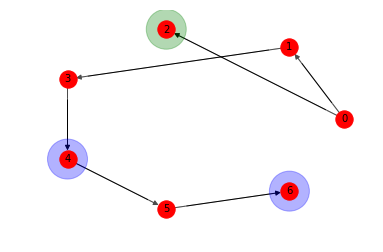

In [147]:
G = nx.DiGraph()
G.add_edges_from([(0,1), (0,2), (1,3), (3,4), (4,5), (5,6)])

_TRUE = {2}
_PRED = {4,6}

pos = nx.circular_layout(G)
val_map = {node: 'green' for node in _TRUE}
for node in _PRED:
    val_map[node] = 'blue' 
    
values = [val_map.get(node, 'white') for node in G.nodes()]

nx.draw_networkx_nodes(G,pos,node_size=1600, cmap=plt.get_cmap('jet'), 
                       node_color = values, alpha=0.3)
nx.draw_networkx_edges(G,pos,width=1,
                           alpha=0.3,edge_color='black')
nx.draw_networkx_labels(G, pos,font_size=10,
                            font_family='sans-serif')
nx.draw(G, pos)
plt.show()

{'source': {'DP': 0, 'p4': 0, 'p6': 0}, 'sink': {'source': 0}, 'DP': {'t2': 0}, 'DT': {'sink': 1}, 'p4': {'DT': 0, 't2': 1}, 'p6': {'DT': 1, 't2': 0}, 't2': {'sink': 0}}
10
0.4444444444444444


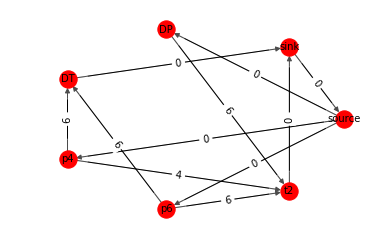

In [148]:
def mgia(TRUE, PRED, G):
    M = len(PRED)
    N = len(TRUE)
    flow= nx.DiGraph()
    G = G.to_undirected()
    infinity = G.number_of_edges()
    flow.add_node('source', demand=0)
    flow.add_node('sink', demand=M-N)
    flow.add_node('DP', demand=0)
    flow.add_node('DT', demand=0)
    flow.add_edge('source', 'DP', capacity=N, weight=0)
    flow.add_edge('DT', 'sink', capacity=M, weight=0)
    flow.add_edge('sink', 'source', capacity=(M)*(N+1), weight=0)
    for pred in PRED:
        _pred = 'p' + str(pred)
        flow.add_node(_pred, demand=-1)
        flow.add_edge('source', _pred, capacity=N, weight=0)
        flow.add_edge(_pred, 'DT', capacity=1, weight=infinity)
    for true in TRUE:
        _true = 't' + str(true)
        flow.add_node(_true, demand=1)
        flow.add_edge(_true, 'sink', capacity=M, weight=0)
        flow.add_edge('DP', _true, capacity=1, weight=infinity)
        for pred in PRED:
            k_ij = nx.shortest_path_length(G, source=pred, target=true)
            flow.add_edge('p' + str(pred), _true, capacity=1, weight=k_ij)
    
    flowCost, flowDict = nx.network_simplex(flow)
    print(flowDict)
    print(flowCost)
    low = (len(_PRED.union(_TRUE).difference(_PRED.intersection(_TRUE))))
    if low == 0:
        accuracy = 1
    else:
        accuracy = 1 - flowCost / (len(_PRED.union(_TRUE).difference(_PRED.intersection(_TRUE))) * infinity)
    print(accuracy)
    
    pos = nx.circular_layout(flow)
    val_map = {node: 'green' for node in TRUE}
    for node in PRED:
        val_map[node] = 'blue'
    values = [val_map.get(node, 'white') for node in flow.nodes()]
    nx.draw_networkx_nodes(flow,pos,node_size=1600, cmap=plt.get_cmap('jet'), 
                       node_color = values, alpha=0.3)
    nx.draw_networkx_edges(flow,pos,width=1,
                               alpha=0.3,edge_color='black')
    nx.draw_networkx_labels(flow, pos,font_size=10,
                                font_family='sans-serif')
    
    labels = nx.get_edge_attributes(flow,'weight')
    nx.draw_networkx_edge_labels(flow,pos,edge_labels=labels)
    nx.draw(flow, pos)
    plt.show()
    
mgia(_TRUE, _PRED, G)

In [136]:
scoring(_TRUE, _PRED, G, 0)

1.0

In [16]:
a = [[1, 2], [3, 5]]
sparse.csr_matrix(a).todense()

matrix([[1, 2],
        [3, 5]], dtype=int32)

In [55]:
np.bitwise_or([0, 0, 1], [0, 1, 1])

array([0, 1, 1], dtype=int32)